In [1]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme() 
import errno
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from scipy import interp
from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

In [2]:
def load_data_south_indian(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=89 and x>=64 else 4 if x<=115 and x>=90 else 5 )
  return df

def load_data_south_pacific(url):
  df = pd.read_csv(url)
  #df.columns = ['id','date','longitude','latitude','speed']
  #df = df.drop(['date'], axis = 1)
  df['category'] = df['Speed(knots)'].apply(lambda x: 
  0 if x<=33 else 1  if x<=47 and x>=34 else 2 if x<=63 and x>=48 else 3 if x<=85 and x>=64 else 4 if x<=107 and x>=86 else 5 )
  return df

In [3]:
ocean = 'south_indian'  #south_indian or south_pacific
print(ocean)

if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific' 

south_indian


In [4]:
df = function(url_data)
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
df.head()

,Basin,No. of Cycl,Time,V5,V6,Lat,Lon,Speed(knots),lat_tenth,lon_tenth,category
0,SI,1,1981072512,BEST,0,118S,867E,20,11.8,86.7,0
1,SI,1,1981072518,BEST,0,116S,864E,25,11.6,86.4,0
2,SI,1,1981072600,BEST,0,113S,862E,25,11.3,86.2,0
3,SI,1,1981072606,BEST,0,109S,862E,25,10.9,86.2,0
4,SI,1,1981072612,BEST,0,104S,861E,25,10.4,86.1,0


In [5]:
def split_sequence(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1 ]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# split a univariate sequence into samples
def uni_split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y) 
 
def rmse(pred, actual):
    return np.sqrt(((pred-actual) ** 2).mean())

def categorical(pred, actual):
  cm = confusion_matrix(pred,actual)
  ps = precision_score(pred,actual,average='micro')
  rs = recall_score(pred,actual,average='micro')
  f1 = f1_score(pred,actual, average = 'micro')
  return cm,ps,rs,f1

def make_confusion_matrix_chart(cf_matrix_test):
    plt.figure(1, figsize=(10,5))
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['0','1'], 
                                xticklabels=['0','1'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.title('Test data')
    return None  

In [6]:
univariate = True # if false, its multivariate case
n_steps_in = 4
n_seq = 2
n_steps_out = 1
n_features_in = 1 #speed
n_features_out = 2 # one hot encoding of category
Hidden = 10
Epochs = 100
Num_Exp = 5

In [7]:
id = df['No. of Cycl'][0]
count = 0
X = []
Y = []
start_index=0
end_index=0
for i in range(1, df.shape[0]):
  if df['No. of Cycl'][i] == id :
    end_index+=1
  else:
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)
    id = df['No. of Cycl'][i]
    start_index=i
    end_index=i
  if i == df.shape[0]-1:   
    x,y = uni_split_sequence(speed[start_index:end_index+1], n_steps_in)
    X.append(x)
    Y.append(y)    

In [8]:
print(len(X), len(Y))
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
print(len(X), len(Y))
print(X[0], Y[0], X[1], Y[1])
print(speed[:10])

670 670
21454 21454
[20 25 25 25] 25 [25 25 25 25] 30
[20, 25, 25, 25, 25, 30, 30, 30, 25, 25]


In [9]:
intensify_y = []
for i in range(len(X)):
  if Y[i]-X[i][0]>=30:
    intensify_y.append(1)
  else:
    intensify_y.append(0)
print(len(intensify_y))
speed_y = Y
Y=intensify_y

21454


In [10]:
train_limit = int(len(X)*70/100)
train_limit

15017

In [11]:
test_X_original = X[train_limit+1:]
#X_original = X[:train_limit]
#X_original = np.asarray(X_original).astype(float)
test_Y_original = Y[train_limit+1:]
#Y_original = Y[:train_limit]
len(X), len(Y), len(test_X_original), len(test_Y_original)

(21454, 21454, 6436, 6436)

In [12]:
X = MinMaxScaler().fit_transform(np.asarray(X))

In [13]:
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(len(test_X), len(test_Y))
len(X), len(Y)

6436 6436


(15017, 15017)

In [14]:
counter_train = Counter(Y)
counter_test = Counter(test_Y)
#counter = collections.OrderedDict(sorted(counter.items()))
print("train data: ", counter_train)
print("test data: ", counter_test)

train data:  Counter({0: 14446, 1: 571})
test data:  Counter({0: 6301, 1: 135})


<Figure size 432x288 with 0 Axes>

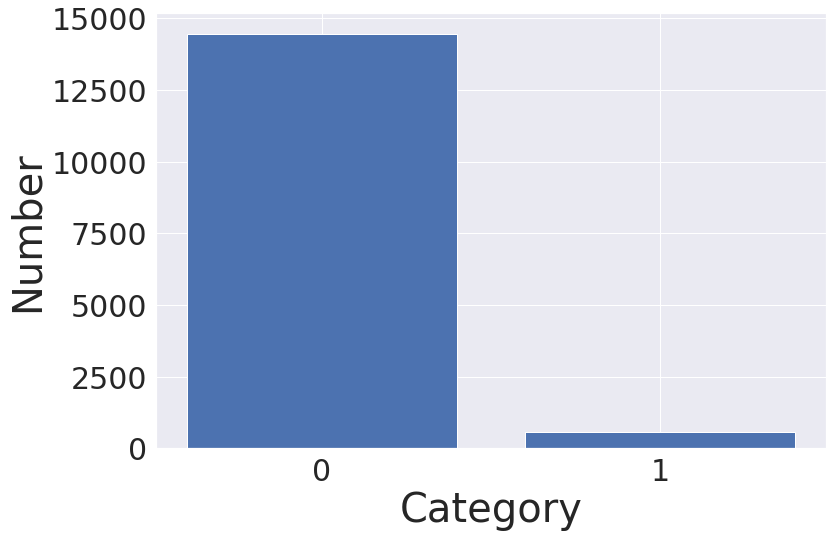

In [15]:
plt.figure()
#fig = plt.subplots(figsize =(20, 12))
fig, ax = plt.subplots(figsize = (12,8))
plt.bar(range(len(counter_train)), list(counter_train.values()), align='center')
plt.xticks(range(len(counter_train)), list(counter_train.keys()))
plt.xlabel('Category', size=40)
plt.ylabel('Number', size=40)
#plt.title('ROC' + ' (' + str(no_of_output_steps) + ' steps ahead, ' + model.capitalize() + ', Time step: ' + str(time_step) + ') - ' + train_or_test.capitalize() + ' (' + ocean + '_ocean)')
ax.tick_params(axis='both', which='major', labelsize=30)
plt.savefig(ocean + '_class_dist.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

In [16]:
def vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features_in)))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model
 
  #model = Sequential()
  #model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in)))
  #model.add(RepeatVector(n_steps_out))
  #model.add(LSTM(Hidden, activation='relu', return_sequences=True))
  #model.add(TimeDistributed(Dense(n_features_out, activation = "softmax")))
  #model.compile(optimizer='adam', loss='categorical_crossentropy')
  #return model

def bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out):
  model = Sequential()
  model.add(Bidirectional(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features_in))))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def cnn_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, int(n_steps_in/n_seq), n_features_in)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(Hidden, activation='relu'))
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

def conv_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, int(n_steps_in/n_seq), n_features_in)))
  model.add(Flatten())
  model.add(Dense(n_features_out, activation = "softmax"))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [17]:
#all models
def MODEL_LSTM(model_name, method, univariate, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)

    if model_name == 'vanilla':
      model = vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out)
    elif model_name == 'bidirectional':
      model = bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out)
    elif model_name == 'cnn-lstm':
      model = cnn_lstm(n_steps_in,n_steps_out,n_features_in,n_features_out,n_seq)
    elif model_name == 'conv-lstm':
      model = conv_lstm(n_steps_in,n_steps_out,n_features_in,n_features_out,n_seq)
    
    #model.summary()

    y_predicttest_allruns = np.zeros([Num_Exp, x_test.shape[0], y_test.shape[1]])

    #print(y_predicttest_allruns.shape, ' shape ')


    Best_f1 = 0  # Assigning a small number
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]
    start_time = time.time()
    Best_report_train = dict()
    Best_report_test = dict()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        scores = model.predict_proba(x_test)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        #y_predicttest_allruns[run,:,:] = y_predicttest
        #train_acc[run] = rmse(y_predicttrain, y_train)
        #print(train_acc[run], 'train accuracy')
        #test_acc[run] = rmse(y_predicttest, y_test)
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]
        report_train = classification_report(act_train, pred_train, labels=[0,1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0,1], output_dict=True)
        #test_acc[run] = f1_score(pred,act, average = 'binary')
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", report_train['1']['f1-score'])        
        print("test acc: ", test_acc[run])
        if test_acc[run] > Best_f1:
            Best_f1 = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_report_train, Best_report_test = report_train, report_test
    model.save("model_" + ocean+"_"+model_name+"_"+method+'.h5')  
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("f1 scores for test data: ", test_acc)
    print("mean: ", np.mean(test_acc), "std dev: ", test_std)
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, scores, Best_report_train, Best_report_test

In [18]:
#idx = np.random.permutation(len(X_smote))
idx = np.random.permutation(len(X))
print(len(idx))
x_shuffled = []
y_shuffled = []
for i in idx:
  #x_shuffled.append(X_smote[i])
  #y_shuffled.append(Y_smote[i])
  x_shuffled.append(X[i])
  y_shuffled.append(Y[i])

15017


In [19]:
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(15017, 2) (6436, 2)


In [20]:
x_shuffled[0], test_X[0]


(array([0.13793103, 0.14285714, 0.14285714, 0.17241379]),
 array([0.10344828, 0.07142857, 0.14285714, 0.17241379]))

In [21]:
#models = ['vanilla', 'bidirectional', 'cnn-lstm', 'conv-lstm']
models = ['vanilla']
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()

In [22]:
for j in range(1):
    predictions_train_per_step = dict()
    actual_train_per_step = dict()  
    predictions_test_per_step = dict()
    actual_test_per_step = dict()
    metrics_train_per_step = dict()
    metrics_test_per_step = dict()
    test_acc_per_step = dict()
    test_stddev_per_step = dict()
    n_steps_out = j+1
    print('---------------------------------------------------------')
    print('no of steps out: ', n_steps_out)

    for i in models:
        print("for " + i + ":")

        if i == 'vanilla' or i=='bidirectional':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))
        elif i == 'cnn-lstm':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
        elif i=='conv-lstm':
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
            x_test = x_test.reshape((x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
        
        #print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, scores, report_train, report_test = MODEL_LSTM(i,'original', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)
        predictions_train_per_step[i] = y_predicttrain
        actual_train_per_step[i] = y_train
        predictions_test_per_step[i] = Best_Predict_Test
        actual_test_per_step[i] = y_test
        metrics_train_per_step[i] = report_train
        metrics_test_per_step[i] = report_test 
        test_acc_per_step[i] = test_acc
        test_stddev_per_step[i] = test_std_dev
    predictions_train[str(j+1)] = predictions_train_per_step 
    actual_train[str(j+1)] = actual_train_per_step
    predictions_test[str(j+1)] = predictions_test_per_step 
    actual_test[str(j+1)] = actual_test_per_step
    metrics_train[str(j+1)] = metrics_train_per_step
    metrics_test[str(j+1)] = metrics_test_per_step
    test_acc_all[str(j+1)] = test_acc_per_step
    test_stddev[str(j+1)] = test_stddev_per_step
  

---------------------------------------------------------
no of steps out:  1
for vanilla:
Experiment 1 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.7577519379844961
test acc:  0.4383561643835616
Experiment 2 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.7552986512524084
test acc:  0.45581395348837217
Experiment 3 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.7533718689788054
test acc:  0.43396226415094336
Experiment 4 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.7579556412729026
test acc:  0.43925233644859807
Experiment 5 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.7551219512195122
test acc:  0.4299065420560747
Total time for 5 experiments 1269.2582051753998
f1 scores for test data:  [0.43835616 0.45581395 0.43396226 0.43925234 0.42990654]
mean:  0.43945825210551004 std dev:  0.0088341045363434


In [23]:
with open("predictions_" + ocean + '_original' + '.pkl', 'wb') as f: 
    pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev], f)

In [24]:
def make_confusion_matrix_chart2(cf_matrix_test, name):
    #plt.figure(figsize=(20,12))
    sns.set(font_scale=2.5)
    fig, ax = plt.subplots(figsize = (20,12))
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['0','1'], 
                                xticklabels=['0','1'], fmt='g')
    plt.ylabel("Actual", size=30)
    plt.xlabel("Pred", size=30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')
    return None 

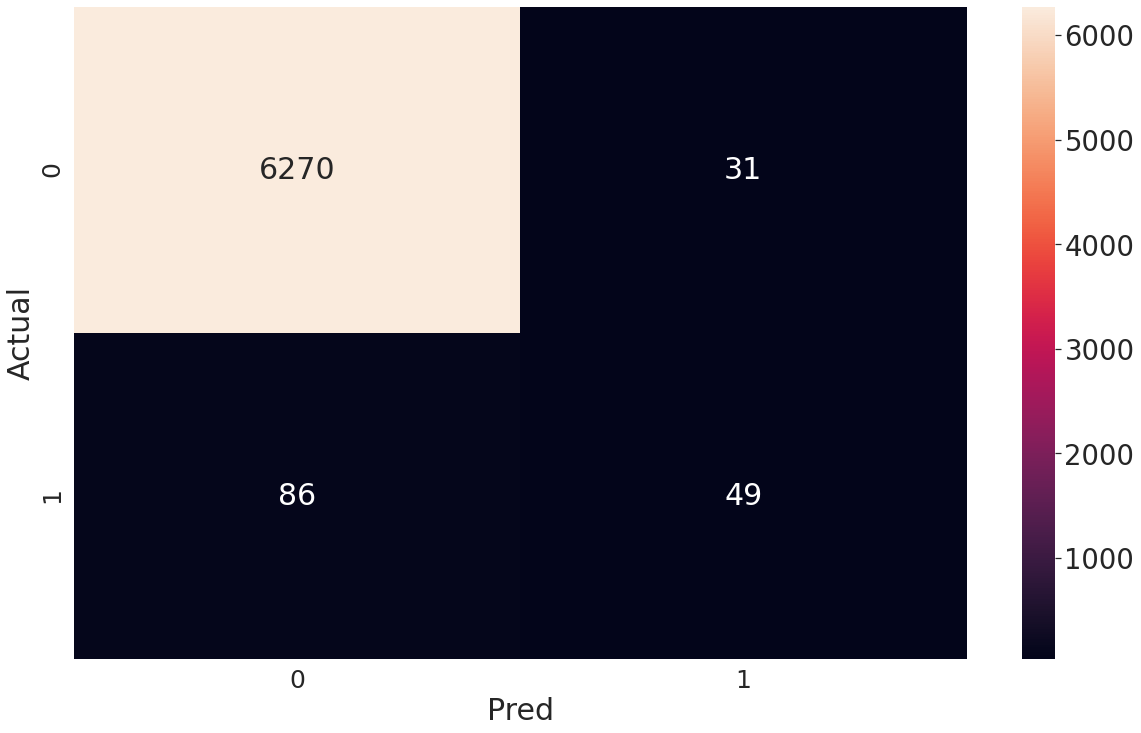

In [25]:
y = [i.argmax() for i in actual_test_per_step['vanilla']]
pred = [i.argmax() for i in predictions_test_per_step['vanilla']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + '_vanilla_cm_original')

In [26]:
report_df = pd.DataFrame(metrics_test_per_step['vanilla']).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.986469,0.995080,0.990756,6301.000000
1,1,0.612500,0.362963,0.455814,135.000000
2,accuracy,0.981821,0.981821,0.981821,0.981821
3,macro avg,0.799485,0.679022,0.723285,6436.000000
4,weighted avg,0.978625,0.981821,0.979535,6436.000000


In [27]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9865 & 0.9951 & 0.9908 & 6301.0 & 
0.6125 & 0.363 & 0.4558 & 135.0 & 
0.9818 & 0.9818 & 0.9818 & 0.9818 & 
0.7995 & 0.679 & 0.7233 & 6436.0 & 
0.9786 & 0.9818 & 0.9795 & 6436.0 & 


In [28]:
oversample = SMOTE()
X_smote, Y_smote = oversample.fit_resample(X, Y)
X_smote = X_smote.astype(np.float)

In [29]:
X.shape, test_X.shape, X_smote.shape

((15017, 4), (6436, 4), (28892, 4))

In [30]:
counter = Counter(Y_smote)
print(counter)
print(len(X_smote), len(X))
print("old smote data after 10000 index: ", Counter(Y_smote[10000:]))

idx = np.random.permutation(len(X_smote))
print(len(idx))

x_shuffled = []
y_shuffled = []
for i in idx:
  x_shuffled.append(X_smote[i])
  y_shuffled.append(Y_smote[i])

print("shuffled smote data after 10000 index: ", Counter(y_shuffled[10000:]))
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

Y_hot_encoded_train.shape, Y_hot_encoded_test.shape

Counter({0: 14446, 1: 14446})
28892 15017
old smote data after 10000 index:  Counter({1: 14016, 0: 4876})
28892
shuffled smote data after 10000 index:  Counter({1: 9527, 0: 9365})


((28892, 2), (6436, 2))

In [31]:
[ i for i in x_shuffled if i[3]>=1]

[]

In [32]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [33]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, scores, report_train, report_test = MODEL_LSTM('vanilla', 'smote', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9698189134808853
test acc:  0.3984526112185686
Experiment 2 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9721060927969297
test acc:  0.41735537190082644
Experiment 3 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9756716008771931
test acc:  0.4171779141104294
Experiment 4 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9781246790592585
test acc:  0.40860215053763443
Experiment 5 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9788594410642466
test acc:  0.4400977995110024
Total time for 5 experiments 2438.33429312706
f1 scores for test data:  [0.39845261 0.41735537 0.41717791 0.40860215 0.4400978 ]
mean:  0.41633716945569227 std dev:  0.013754992325834532


**SMOTE Results**

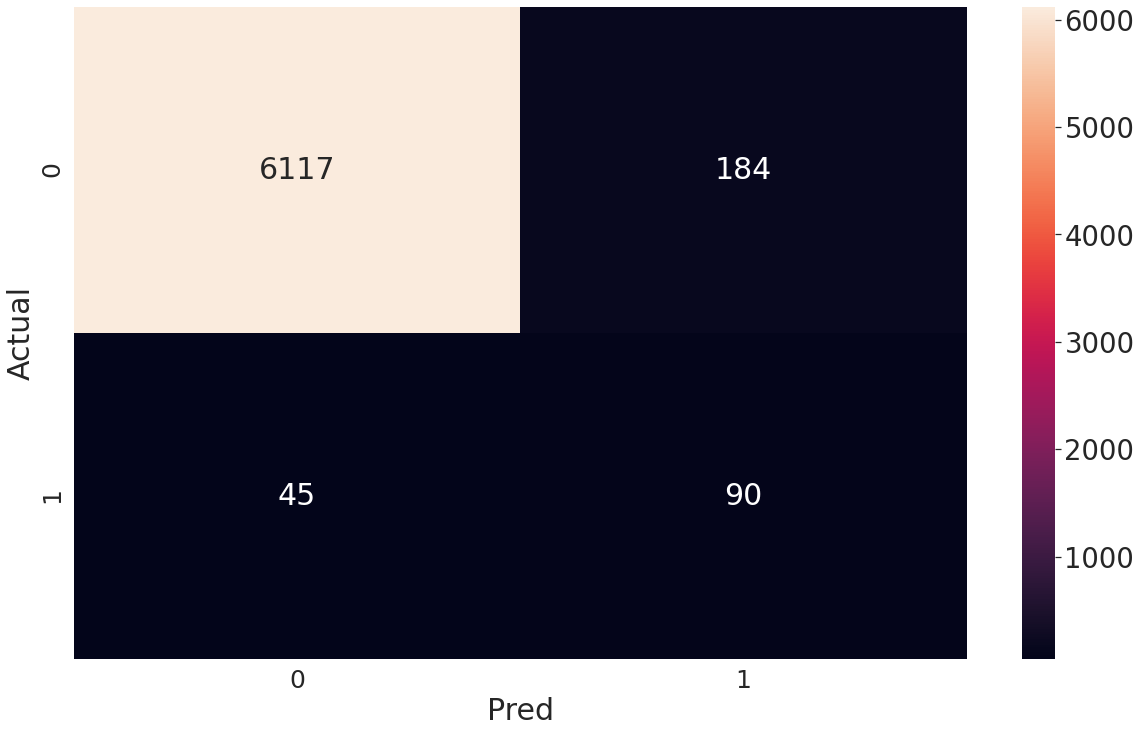

In [34]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + '_vanilla_cm_smote')

In [35]:
with open("predictions_" + ocean + '_smote' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_std_dev], f)

In [36]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.992697,0.970798,0.981626,6301.000000
1,1,0.328467,0.666667,0.440098,135.000000
2,accuracy,0.964419,0.964419,0.964419,0.964419
3,macro avg,0.660582,0.818732,0.710862,6436.000000
4,weighted avg,0.978764,0.964419,0.970267,6436.000000


In [37]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9927 & 0.9708 & 0.9816 & 6301.0 & 
0.3285 & 0.6667 & 0.4401 & 135.0 & 
0.9644 & 0.9644 & 0.9644 & 0.9644 & 
0.6606 & 0.8187 & 0.7109 & 6436.0 & 
0.9788 & 0.9644 & 0.9703 & 6436.0 & 


In [38]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

**Simple GAN**

In [39]:
x_shuffled = X
y_shuffled = Y

In [40]:
len(x_shuffled), len(X), len(y_shuffled)

(15017, 15017, 15017)

In [41]:
t2 = np.asarray(x_shuffled).shape
X_oversampled = torch.from_numpy(np.asarray(x_shuffled))

In [42]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):

    def __init__(self, z_dim=t2[1], im_dim=t2[1], hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen(self):

        return self.gen
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class Discriminator(nn.Module):
    def __init__(self, im_dim=t2[1], hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):

        return self.disc(image)
    
    def get_disc(self):

        return self.dis
def get_noise(n_samples, z_dim, device='cuda'):

    return torch.randn(n_samples,z_dim,device=device) 

In [43]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = t2[1]
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cpu'
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [44]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [45]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==1:
        li.append(x_shuffled[i])
        
len(y_shuffled), len(li)

(15017, 571)

In [46]:
X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

(571,)

In [47]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

In [48]:
samples_to_generate = X_oversampled.shape[0]-X_real.shape[0]
print(samples_to_generate)

14446


In [49]:
#epochs = [100,500,1000,2000,3000,4000,5000]
epochs = [2000]

In [50]:
original_gan_data = dict()

In [51]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  for epoch in range(no_epoch):
  
   
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real)

       
        real = real.view(cur_batch_size, -1).to(device)

      
       
        disc_opt.zero_grad()

       
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        if epoch%500==0:
            print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.ones(samples_to_generate)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  print(finX.shape, finY.shape)
  #idx = np.random.permutation(len(X_smote))
  idx = np.random.permutation(finX.shape[0])
  print(len(idx))
  x_shuffled = []
  y_shuffled = []
  xy=dict()
  for i in idx:
    #x_shuffled.append(X_smote[i])
    #y_shuffled.append(Y_smote[i])
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  xy['x_shuffled']=x_shuffled
  xy['y_shuffled']=y_shuffled
  original_gan_data[no_epoch]=xy

no of epochs:  2000
Epoch 0: Step 0: Generator loss: 0.7433004379272461, discriminator loss: 0.6898788213729858
Epoch 0: Step 1: Generator loss: 1.4869296550750732, discriminator loss: 1.3797531127929688
Epoch 0: Step 2: Generator loss: 0.74413001537323, discriminator loss: 0.6902968287467957
Epoch 0: Step 3: Generator loss: 0.7444279193878174, discriminator loss: 0.6904038190841675
Epoch 0: Step 4: Generator loss: 0.744897186756134, discriminator loss: 0.6886842250823975
Epoch 500: Step 2500: Generator loss: 0.7027942538261414, discriminator loss: 0.6932023763656616
Epoch 500: Step 2501: Generator loss: 0.7027704119682312, discriminator loss: 0.6931785345077515
Epoch 500: Step 2502: Generator loss: 0.702828049659729, discriminator loss: 0.6932562589645386
Epoch 500: Step 2503: Generator loss: 0.7027342319488525, discriminator loss: 0.6931048035621643
Epoch 500: Step 2504: Generator loss: 0.7028638124465942, discriminator loss: 0.6931381225585938
Epoch 1000: Step 5000: Generator loss: 

In [52]:
with open(ocean + '_original_gan_data' + '.pkl', 'wb') as f: 
    pickle.dump([original_gan_data], f)

In [53]:
len(original_gan_data[2000]['x_shuffled']), len(original_gan_data[2000]['y_shuffled'])

(29463, 29463)

In [54]:
x_shuffled = original_gan_data[2000]['x_shuffled']
y_shuffled = original_gan_data[2000]['y_shuffled']

In [55]:
len(test_Y), test_X.shape

(6436, (6436, 4))

In [56]:
Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(29463, 2) (6436, 2)


In [57]:
test_X

array([[0.10344828, 0.07142857, 0.14285714, 0.17241379],
       [0.10344828, 0.14285714, 0.14285714, 0.17241379],
       [0.17241379, 0.14285714, 0.14285714, 0.17241379],
       ...,
       [0.24137931, 0.14285714, 0.10714286, 0.13793103],
       [0.17241379, 0.10714286, 0.10714286, 0.10344828],
       [0.10344828, 0.03571429, 0.03571429, 0.06896552]])

In [58]:
x_shuffled[0], y_shuffled[0]

(array([0.13331954, 0.18669145, 0.23320237, 0.33463877]), 1.0)

In [59]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [60]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, scores, report_train, report_test = MODEL_LSTM('vanilla', 'gan', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9907073138120068
test acc:  0.4095238095238095
Experiment 2 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9908079018618178
test acc:  0.38862559241706157
Experiment 3 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9914489945888169
test acc:  0.4201680672268907
Experiment 4 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.991409566467226
test acc:  0.4351851851851852
Experiment 5 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9918421932464059
test acc:  0.4186046511627907
Total time for 5 experiments 2513.894284963608
f1 scores for test data:  [0.40952381 0.38862559 0.42016807 0.43518519 0.41860465]
mean:  0.4144214611031475 std dev:  0.015304042805964133


In [61]:
with open("predictions_" + ocean + '_gan' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_std_dev], f)

**GAN Results**

In [62]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.986153,0.994604,0.990360,6301.000000
1,1,0.580247,0.348148,0.435185,135.000000
2,accuracy,0.981044,0.981044,0.981044,0.981044
3,macro avg,0.783200,0.671376,0.712773,6436.000000
4,weighted avg,0.977638,0.981044,0.978715,6436.000000


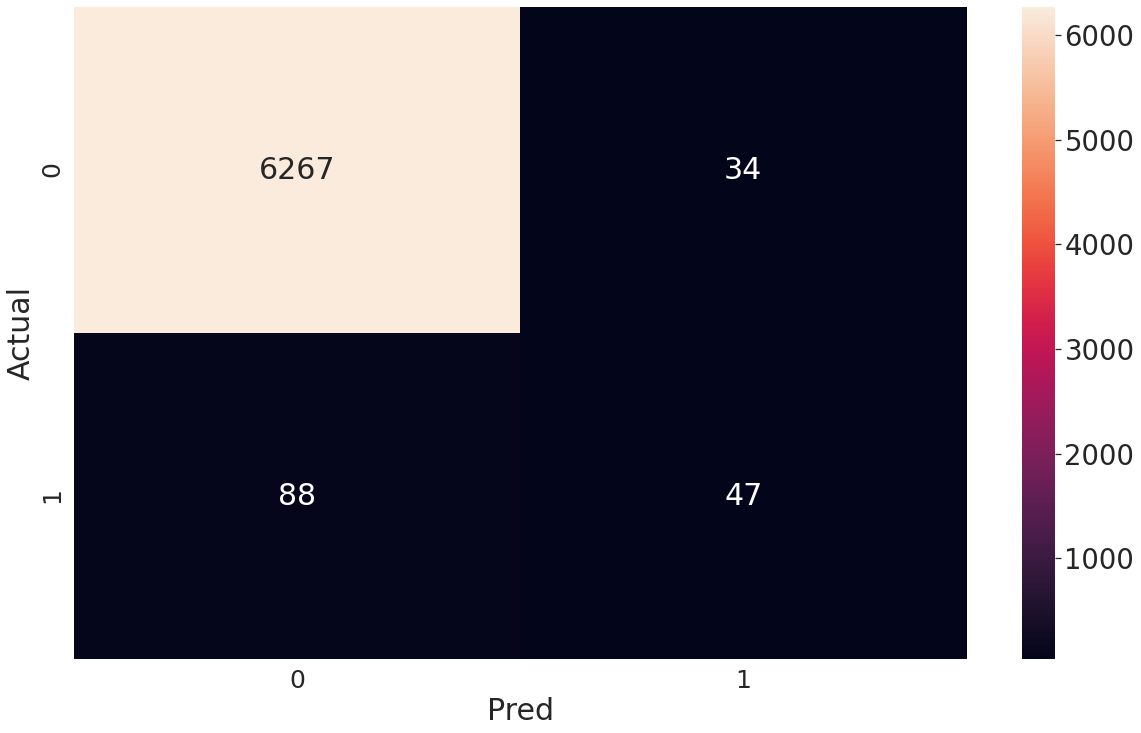

In [63]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + 'vanilla_cm_gan')

In [64]:
f1_score(y, pred, average="micro")

0.981044126786824

In [65]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9862 & 0.9946 & 0.9904 & 6301.0 & 
0.5802 & 0.3481 & 0.4352 & 135.0 & 
0.981 & 0.981 & 0.981 & 0.981 & 
0.7832 & 0.6714 & 0.7128 & 6436.0 & 
0.9776 & 0.981 & 0.9787 & 6436.0 & 


In [66]:
torch.cuda.empty_cache()

In [67]:
x_shuffled = X_smote
y_shuffled = Y_smote
print(len(x_shuffled), len(X), len(y_shuffled)) 
t2 = np.asarray(x_shuffled).shape
X_oversampled = torch.from_numpy(np.asarray(x_shuffled))

28892 15017 28892


In [68]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class Generator(nn.Module):

    def __init__(self, z_dim=t2[1], im_dim=t2[1], hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    
    def get_gen(self):

        return self.gen
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class Discriminator(nn.Module):
    def __init__(self, im_dim=t2[1], hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):

        return self.disc(image)
    
    def get_disc(self):

        return self.dis
def get_noise(n_samples, z_dim, device='cuda'):

    return torch.randn(n_samples,z_dim,device=device) 

In [69]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1000
z_dim = t2[1]
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cpu'
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [70]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [71]:
li=[]
for i in range(len(y_shuffled)):
    if int(y_shuffled[i])==1:
        li.append(x_shuffled[i])
        
print(len(y_shuffled), len(li))

X_real=np.array(li)
t3=X_real.shape
li2=[1]*(t3[0])
y_real=np.array(li2)
y_real.shape

from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(X_real) 
tensor_y = torch.Tensor(y_real)
my_dataset = TensorDataset(tensor_x,tensor_y)
dataloader = DataLoader(
    my_dataset,
    batch_size=batch_size,
    shuffle=True)

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

28892 14446


In [72]:
samples_to_generate = X_oversampled.shape[0]-X_real.shape[0]
print(samples_to_generate)

#epochs = [100,500,1000,2000,3000,4000,5000]
epochs = [2000]

smote_gan_data = dict()

14446


In [73]:
for no_epoch in epochs:
  print("no of epochs: ", no_epoch)
  for epoch in range(no_epoch):
  
   
    for real, _ in tqdm(dataloader, disable=True):
        cur_batch_size = len(real)

       
        real = real.view(cur_batch_size, -1).to(device)

      
       
        disc_opt.zero_grad()

       
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        if epoch%500==0:
            print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

        if cur_step % display_step == 0 and cur_step > 0:
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
  fake_noise = get_noise(samples_to_generate, z_dim, device=device)
  res=gen(fake_noise)
  fres=res.cpu().detach().numpy()
  X_old=X
  finX=np.concatenate((X_old, fres), axis=0)
  y_fake = np.ones(samples_to_generate)
  Y_old=np.asarray(Y)
  finY = np.append(Y_old, y_fake, axis=0)
  print(finX.shape, finY.shape)
  #idx = np.random.permutation(len(X_smote))
  idx = np.random.permutation(finX.shape[0])
  print(len(idx))
  x_shuffled = []
  y_shuffled = []
  xy=dict()
  for i in idx:
    #x_shuffled.append(X_smote[i])
    #y_shuffled.append(Y_smote[i])
    x_shuffled.append(finX[i])
    y_shuffled.append(finY[i])
  xy['x_shuffled']=x_shuffled
  xy['y_shuffled']=y_shuffled
  smote_gan_data[no_epoch]=xy

no of epochs:  2000
Epoch 0: Step 0: Generator loss: 0.7347007989883423, discriminator loss: 0.6949118375778198
Epoch 0: Step 1: Generator loss: 1.469479262828827, discriminator loss: 1.3897688388824463
Epoch 0: Step 2: Generator loss: 0.7346934676170349, discriminator loss: 0.6945462226867676
Epoch 0: Step 3: Generator loss: 0.7345662117004395, discriminator loss: 0.694498598575592
Epoch 0: Step 4: Generator loss: 0.7345219254493713, discriminator loss: 0.6943708658218384
Epoch 0: Step 5: Generator loss: 0.7343059182167053, discriminator loss: 0.6940597295761108
Epoch 0: Step 6: Generator loss: 0.7341628074645996, discriminator loss: 0.6941660046577454
Epoch 0: Step 7: Generator loss: 0.7340083122253418, discriminator loss: 0.694237470626831
Epoch 0: Step 8: Generator loss: 0.7338768243789673, discriminator loss: 0.6940128803253174
Epoch 0: Step 9: Generator loss: 0.7337404489517212, discriminator loss: 0.6940609812736511
Epoch 0: Step 10: Generator loss: 0.733531653881073, discrimina

In [74]:
with open(ocean + '_smote_gan_data' + '.pkl', 'wb') as f: 
    pickle.dump([smote_gan_data], f)

In [75]:
print(len(smote_gan_data[2000]['x_shuffled']), len(smote_gan_data[2000]['y_shuffled']))
x_shuffled = smote_gan_data[2000]['x_shuffled']
y_shuffled = smote_gan_data[2000]['y_shuffled']
print(len(test_Y), test_X.shape)

Y_hot_encoded_train =  np.asarray(to_categorical(y_shuffled))
#Y_hot_encoded_train = Y_hot_encoded_train.reshape(len(y_shuffled), n_steps_out, n_features_out)

Y_hot_encoded_test =  np.asarray(to_categorical(test_Y))
#Y_hot_encoded_test = Y_hot_encoded_test.reshape(len(test_Y), n_steps_out, n_features_out)

print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

29463 29463
6436 (6436, 4)
(29463, 2) (6436, 2)


In [76]:
test_X

array([[0.10344828, 0.07142857, 0.14285714, 0.17241379],
       [0.10344828, 0.14285714, 0.14285714, 0.17241379],
       [0.17241379, 0.14285714, 0.14285714, 0.17241379],
       ...,
       [0.24137931, 0.14285714, 0.10714286, 0.13793103],
       [0.17241379, 0.10714286, 0.10714286, 0.10344828],
       [0.10344828, 0.03571429, 0.03571429, 0.06896552]])

In [77]:
x_shuffled[0], y_shuffled[0]

(array([0.42247275, 0.42667603, 0.52895534, 0.58536875]), 1.0)

In [78]:
            x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
            x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
            x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
            x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

In [79]:
train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, scores, report_train, report_test = MODEL_LSTM('vanilla', 'smote_gan', univariate,x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs, Hidden)

Experiment 1 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.984292847458748
test acc:  0.35911602209944754
Experiment 2 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9880102294994852
test acc:  0.3694267515923567
Experiment 3 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.98908776365693
test acc:  0.3505154639175258
Experiment 4 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9907503255751828
test acc:  0.3710407239819004
Experiment 5 in progress


/home/z5239100/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train acc:  0.9904087157036394
test acc:  0.3902439024390244
Total time for 5 experiments 2502.5029335021973
f1 scores for test data:  [0.35911602 0.36942675 0.35051546 0.37104072 0.3902439 ]
mean:  0.368068572806051 std dev:  0.013346785173707042


In [80]:
with open("predictions_" + ocean + '_smote_gan' + '.pkl', 'wb') as f: 
    pickle.dump([y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_std_dev], f)

**SMOTE GAN results**

In [81]:
report_df = pd.DataFrame(report_test).transpose()
report_df = report_df.reset_index()
model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
report_df

,index,precision,recall,f1-score,support
0,0,0.985077,0.995239,0.990132,6301.000000
1,1,0.571429,0.296296,0.390244,135.000000
2,accuracy,0.980578,0.980578,0.980578,0.980578
3,macro avg,0.778253,0.645768,0.690188,6436.000000
4,weighted avg,0.976400,0.980578,0.977549,6436.000000


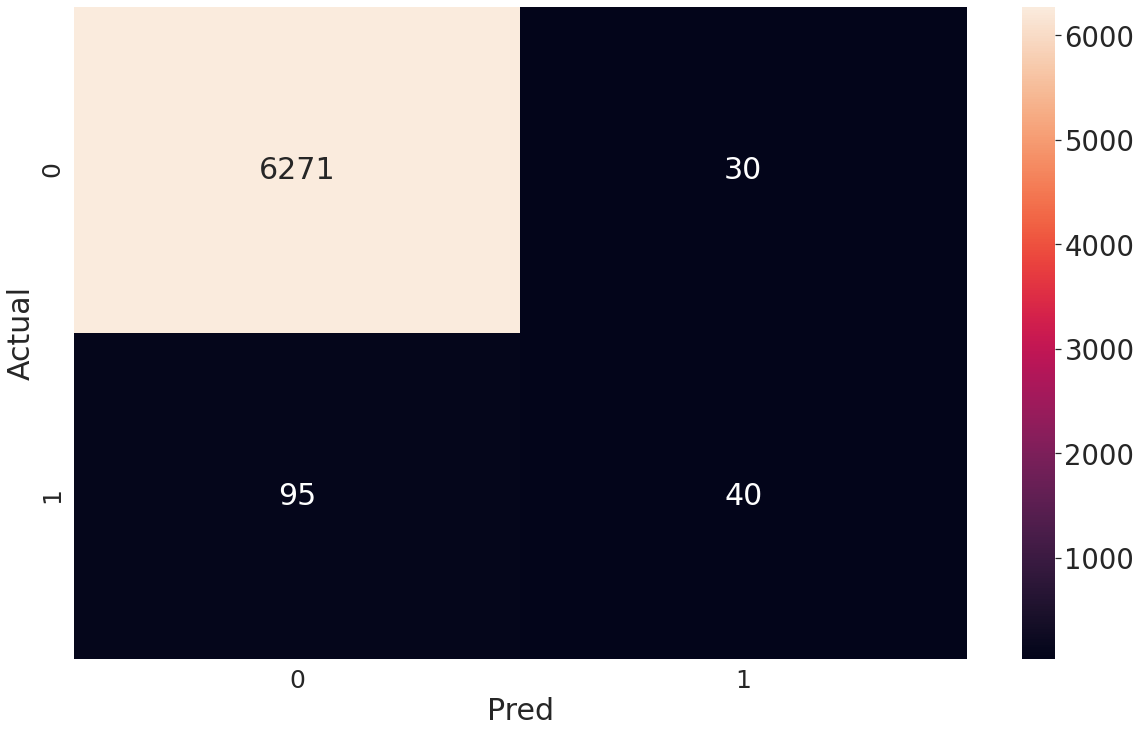

In [82]:
y = [i.argmax() for i in y_test]
pred = [i.argmax() for i in Best_Predict_Test]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart2(cf_matrix_test, ocean + 'vanilla_cm_smote_gan')

In [83]:
for i in range(report_df.shape[0]):
  tmp=""
  for j in ['precision', 'recall', 'f1-score', 'support']:
    tmp=tmp+ str(round(report_df[j][i],4)) + " & "
  print(tmp)

0.9851 & 0.9952 & 0.9901 & 6301.0 & 
0.5714 & 0.2963 & 0.3902 & 135.0 & 
0.9806 & 0.9806 & 0.9806 & 0.9806 & 
0.7783 & 0.6458 & 0.6902 & 6436.0 & 
0.9764 & 0.9806 & 0.9775 & 6436.0 & 


**Recall Precision curves**

In [84]:
with open('predictions_'+ ocean + '_original' + '.pkl', 'rb') as f: 
    predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev=pickle.load(f)

In [85]:
lr_probs = predictions_test['1']['vanilla']
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in actual_test['1']['vanilla']]
yhat= [i.argmax() for i in predictions_test['1']['vanilla']]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

[7.2182893e-06 1.9666984e-06 4.7528505e-11 ... 1.5341984e-17 9.2376329e-15
 5.2768822e-12]
Logistic: f1=0.456 auc=0.533


In [86]:
with open('predictions_'+ ocean + '_smote' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_stddev = pickle.load(f)

In [87]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_smote, lr_recall_smote, _ = precision_recall_curve(testy, lr_probs)
lr_f1_smote, lr_auc_smote = f1_score(testy, yhat), auc(lr_recall_smote, lr_precision_smote)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_smote, lr_auc_smote))

[6.4129190e-06 8.1692754e-22 1.4887217e-13 ... 0.0000000e+00 8.8478137e-33
 0.0000000e+00]
Logistic: f1=0.440 auc=0.432


In [88]:
with open('predictions_'+ ocean + '_gan' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_stddev = pickle.load(f)

In [89]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_gan, lr_recall_gan, _ = precision_recall_curve(testy, lr_probs)
lr_f1_gan, lr_auc_gan = f1_score(testy, yhat), auc(lr_recall_gan, lr_precision_gan)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_gan, lr_auc_gan))

[1.6288745e-06 1.2833248e-08 1.0904146e-10 ... 1.2435633e-27 1.2029738e-20
 1.9051564e-33]
Logistic: f1=0.435 auc=0.495


In [90]:
with open('predictions_'+ ocean + '_smote_gan' + '.pkl', 'rb') as f: 
    y_predicttrain, y_train, Best_Predict_Test, y_test, report_train, report_test, test_acc, test_stddev = pickle.load(f)

In [91]:
lr_probs = Best_Predict_Test
lr_probs = lr_probs[:, 1]
print(lr_probs)
testy= [i.argmax() for i in y_test]
yhat= [i.argmax() for i in Best_Predict_Test]
lr_precision_smote_gan, lr_recall_smote_gan, _ = precision_recall_curve(testy, lr_probs)
lr_f1_smote_gan, lr_auc_smote_gan = f1_score(testy, yhat), auc(lr_recall_smote_gan, lr_precision_smote_gan)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1_smote_gan, lr_auc_smote_gan))

[4.2193074e-06 1.6528141e-08 4.9873395e-16 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
Logistic: f1=0.390 auc=0.450


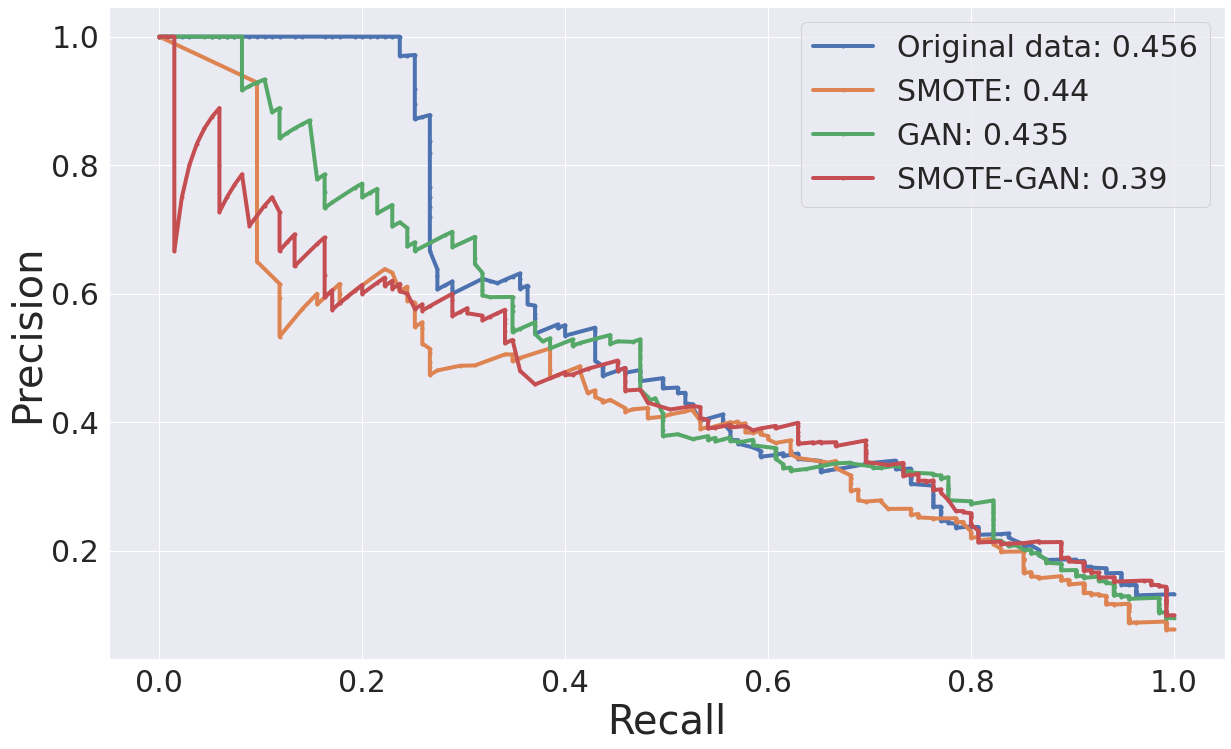

In [92]:
# plot the precision-recall curves
fig, ax = pyplot.subplots(figsize = (20,12))
no_skill = 135 / len(testy)    #no of one/total
pyplot.plot(lr_recall, lr_precision, marker='.',lw=4, label='Original data: ' + str(round(lr_f1,3)))
pyplot.plot(lr_recall_smote, lr_precision_smote,lw=4, marker='.', label='SMOTE: ' + str(round(lr_f1_smote,3)))
pyplot.plot(lr_recall_gan, lr_precision_gan,lw=4, marker='.', label='GAN: ' + str(round(lr_f1_gan,3)))
pyplot.plot(lr_recall_smote_gan, lr_precision_smote_gan,lw=4, marker='.', label='SMOTE-GAN: ' + str(round(lr_f1_smote_gan,3)))
# axis labels
pyplot.xlabel('Recall', size=40)
pyplot.ylabel('Precision', size=40)
ax.tick_params(axis='both', which='major', labelsize=30)
# show the legend
pyplot.legend(loc="upper right", fontsize=30)
#save the plot
plt.savefig(ocean + '_precision_recall_curve.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
# show the plot
pyplot.show()